## Modelos de Pronóstico de Huracanes

Los huracanes son tormentas de gran escala con vientos de al menos 119 km/h (74 mph), 
caracterizadas por un centro de baja presión, circulación cerrada en niveles bajos, 
fuertes vientos y tormentas organizadas en espiral que producen intensas lluvias.  
Sus efectos destructivos incluyen daños costeros por vientos, lluvias, marejadas 
ciclónicas y posibles tornados. Además, al concentrar la humedad atmosférica y la 
evaporada del océano, generan precipitaciones extremas e inundaciones que pueden 
afectar áreas hasta 40 km tierra adentro.

El **Centro Nacional de Huracanes (NHC)** utiliza **modelos de pronóstico** para 
predecir la trayectoria e intensidad de las tormentas, lo que guía la elaboración de 
los informes oficiales. Estos modelos emplean distintas técnicas matemáticas y 
estadísticas, como **regresión múltiple, sistemas dinámicos y crecimiento logístico**.  
Algunos se centran en aspectos específicos de la tormenta, por ejemplo, el **LGEM 
(Logistic Growth Equation Model)**, que estima la intensidad en función del contenido 
de calor oceánico.

Con el fin de comprender mejor estos fenómenos y reducir pérdidas humanas y materiales, 
se propone el desarrollo de un modelo que prediga la **velocidad máxima sostenida del 
viento** en ciclones tropicales al momento de tocar tierra.


# Supuestos para un modelo de MSWS tras el impacto

## Objetivo
Construir un modelo matemático que prediga la **velocidad máxima sostenida del viento (MSWS)** de un ciclón tropical una vez que ha tocado tierra. Para mantener el modelo manejable debemos introducir supuestos simplificadores: a continuación se listan posibilidades, se discuten su importancia y cómo podrían incorporarse en el modelo.

---

## Lista de consideraciones

### 1. Temperatura del mar 
**Importancia:** Alta. La energía disponible para la tormenta depende fuertemente de la temperatura superficial del mar (SST) y del contenido de calor oceánico; si parte de la circulación permanece sobre agua, la decaimiento será más lento.  
**Cómo incluirlo:** tratar la temperatura del mar como un factor que reduce la tasa de decaimiento; por ejemplo, la constante de decaimiento `α` puede depender negativamente de SST en la franja costera o de la fracción del núcleo aún sobre agua (`alpha = alpha0 * f(SST, fracción_sobre_agua)`).

### 2. Aire seco (dry air)
**Importancia:** Media. La intrusión de aire seco puede debilitar la convección y acelerar la pérdida de intensidad, pero su efecto local es más difícil de cuantificar sin datos radiosondales/observaciones.  
**Cómo incluirlo:** como un factor multiplicativo sobre `α` o sobre la tasa de reconstitución convectiva; en un modelo simple puede ignorarse o incluirse como un término de corrección si existen mediciones (humedad relativa en capas claves).

### 3. Cizalladura vertical del viento (vertical wind shear)
**Importancia:** Alta. La cizalladura vertical puede desorganizar la estructura del ciclón y acelerar el debilitamiento.  
**Cómo incluirlo:** modelar `α` como crecientemente dependiente de la cizalladura (`alpha = alpha0 + c1 * shear`), o introducir un término que degrade el máximo posible `v_b` cuando la cizalladura supera cierto umbral.

### 4. Tamaño de la tormenta (size of storm)
**Importancia:** Media–Alta. Tormentas grandes suelen decaer con distinta dinámica (inercia mayor, mayor cubierta de humedad) que tormentas pequeñas.  
**Cómo incluirlo:** introducir un término que ajuste la sensibilidad al rozamiento terrestre: por ejemplo `alpha` podría ser proporcional a `1/R` (R = radio característico), o introducir diferentes parámetros `alpha_small`, `alpha_large`.

### 5. Localización del impacto (location of storm)
**Importancia:** Alta. Características del terreno (suavidad/roughness), orografía, y si el centro queda parcialmente sobre agua determinan la tasa de debilitamiento.  
**Cómo incluirlo:** modelar una **fracción sobre agua** `f_w` (0 a 1) y/o un coeficiente de rugosidad `z0` de la costa/terreno; `α` y/o `v_b` dependen de `f_w` y `z0`.

---

## Supuestos recomendados

### A) Modelo **muy simple** (mínimos supuestos)
- Supuesto: El viento decae exponencialmente según la distancia al mar (o tiempo desde tierra), con una constante de decaimiento `α` fija.  
- Ignorar: aire seco y cizalladura.   
- Ecuación básica: `dv/dt = -α (v - v_b)` con `v_b` constante (valor límite > 0 si hay flujo residual).

### B) Modelo **intermedio**
- Incluir: fracción de circulación aún sobre agua `f_w`, cizalladura `S`, tamaño `R`.  
- Supuesto: `α` depende linealmente de `S`, `R`, y `f_w`; `v_b` depende de `f_w` y SST.  
- Forma sugerida: `dv/dt = -α(v,S,R,f_w) * (v - v_b(f_w, SST))` con, por ejemplo, `α = α0 + a1S + a2(1/R) + a3*(1 - f_w)` y `v_b = v_b0 + b1 * f_w * (SST - SST0)` donde `α0, a1, a2, a3, v_b0, b1` se estiman por ajuste a datos históricos (p. ej. Solver o regresión no lineal).

### C) Modelo **complejo / operativo**
- Incluir además: variaciones temporales de SST, intrusión de aire seco (humedad), interacción con orografía y procesos dinámicos no lineales.  
- Requiere: datos observacionales detallados y/o modelo numérico.

---

## Justificación práctica y prioridades
1. **Prioridad alta:** `location` (fracción sobre agua / rugosidad) y `vertical wind shear` — ambos afectan fuertemente la tasa de debilitamiento y son relativamente simples de parametrizar.  
2. **Prioridad alta:** `sea temperatures` — crítica si parte del sistema permanece sobre agua; influye en `v_b`.  
3. **Prioridad media:** `size of storm` — importante pero puede tratarse con una corrección simple (1/R).  
4. **Prioridad baja/condicional:** `dry air` — influye, pero su cuantificación requiere observaciones verticales; incluirlo cuando se disponga de datos.






# Solución detallada para el modelo A

## Modelo simple
El supuesto dice que la velocidad decae en proporción a su valor actual. Entonces:

$$
\frac{dv}{dt} = -\alpha\, v(t), \quad \alpha>0
$$

## Separación de variables
$$
\frac{dv}{v} = -\alpha\, dt
$$

Integrando:

$$
\ln|v| = -\alpha t + C
$$

$$
v(t) = C_1 e^{-\alpha t}, \quad C_1>0
$$

## Condición inicial
Con $v(0)=v_0$:

$$
C_1 = v_0
$$

Por tanto:

$$
\boxed{v(t)=v_0 e^{-\alpha t}}
$$

## Límite cuando $t\to\infty$
$$
\lim_{t\to\infty} v(t) = v_0 \cdot \lim_{t\to\infty} e^{-\alpha t} = 0
$$

**Observación:** este modelo simple predice que la velocidad tiende a 0.  
Sin embargo, en la realidad se observa un valor límite **no nulo**.

## Ajuste del modelo con límite no nulo
Si la velocidad tiende a un valor $v_b$ cuando $t\to\infty$, planteamos:

$$
\frac{dv}{dt} = -\alpha\,(v(t)-v_b)
$$

## Resolución de la nueva ODE
Separación de variables:

$$
\frac{dv}{v-v_b} = -\alpha\, dt
$$

Integrando:

$$
\ln|v-v_b| = -\alpha t + C
$$

$$
v(t)-v_b = C_1 e^{-\alpha t}
$$

Usando $v(0)=v_0$:

$$
C_1 = v_0 - v_b
$$

## Solución final
$$
\boxed{v(t) = v_b + (v_0 - v_b)\,e^{-\alpha t}}
$$

---

## Propiedades
- Límite:
  $$
  \lim_{t\to\infty} v(t) = v_b
  $$
- $\alpha$ mide la rapidez del decaimiento.
- $v_b$ representa una velocidad residual (no nula) a largo plazo.
- Tiempo característico: 
  $$
  \tau = \frac{1}{\alpha}, \quad 
  t_{1/2} = \frac{\ln 2}{\alpha}
  $$

---


# Estimación de $v_0$, $\alpha$ y $v_b$ a partir de datos (Irma y Michael)

**Objetivo:** Usar los datos provistos para estimar los parámetros $\alpha$ (constante de decaimiento, en 1/hora) y $v_b$ (velocidad límite cuando $t\to\infty$) del modelo
$$
v(t) = v_b + (v_0 - v_b)\,e^{-\alpha t},
$$
donde $v_0$ es la MSWS al instante de landfall (conocido a partir del primer dato).

---

## Datos (tomados del enunciado)

**Irma** (tiempo en horas, velocidad en mph):

$$
\begin{aligned}
t_{\text{irma}} &= [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,21,24,27,30,33,36,39],\\
v_{\text{irma}} &= [130,130,130,120,120,115,110,110,110,105,105,105,100,100,100,100,75,70,65,60,50,45,35,25].
\end{aligned}
$$

**Michael** (tiempo en horas, velocidad en mph):

$$
\begin{aligned}
t_{\text{michael}} &= [0,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,13.5,16.5,19.5,22.5,25.5,28.5,31.5,34.5,37.5,40.5],\\
v_{\text{michael}} &= [160,155,150,140,125,115,100,90,85,80,75,70,60,50,50,50,50,50,50,50,60,65].
\end{aligned}
$$

---


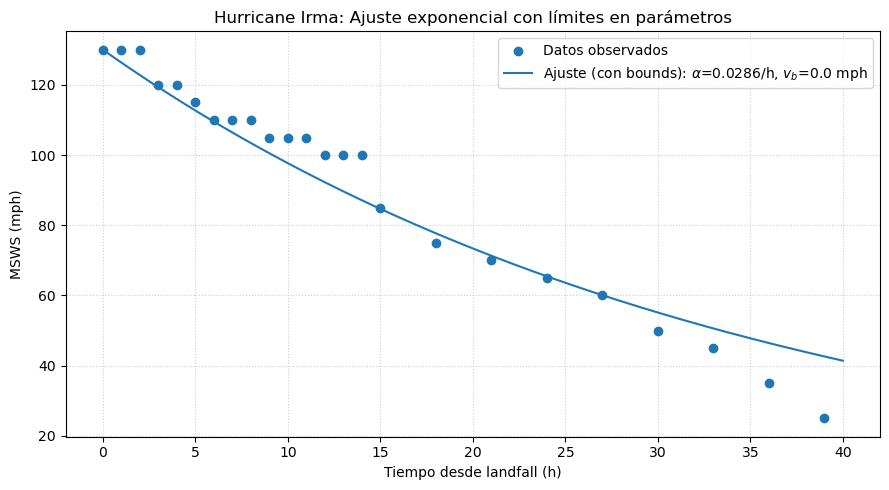

(0.028598216116198442,
 0.008013187654272221,
 8.27810109225944e-15,
 25.03668267645871)

In [3]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# --- Datos de Irma (t, v) ---
t_irma = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,21,24,27,30,33,36,39], dtype=float)
v_irma = np.array([130,130,130,120,120,115,110,110,110,105,105,105,100,100,100,85,75,70,65,60,50,45,35,25], dtype=float)

# --- Modelo ---
def v_model(t, alpha, v_b, v0):
    return v_b + (v0 - v_b) * np.exp(-alpha * t)

# --- Ajuste con bounds: fijar v0 al primer valor ---
v0 = v_irma[0]
def model_for_fit(t, alpha, v_b):
    return v_model(t, alpha, v_b, v0)

# Bounds: alpha in [1e-4, 2.0]  (1e-4 to 2 per hour), v_b in [0, v0]
lower_bounds = [1e-4, 0.0]
upper_bounds = [2.0, v0]
p0 = [0.1, 30]  # initial guesses

popt, pcov = curve_fit(model_for_fit, t_irma, v_irma, p0=p0, bounds=(lower_bounds, upper_bounds), maxfev=100000)
alpha_hat, v_b_hat = popt
# Estimate parameter uncertainties (handle case where pcov may be inf/nan)
with np.errstate(invalid='ignore'):
    perr = np.sqrt(np.diag(pcov))
    perr = np.where(np.isfinite(perr), perr, np.array([np.nan, np.nan]))

# --- Valores predichos ---
t_fit = np.linspace(0, 40, 300)
v_fit = model_for_fit(t_fit, alpha_hat, v_b_hat)

# --- Plot ---
plt.figure(figsize=(9,5))
plt.scatter(t_irma, v_irma, label="Datos observados", zorder=5)
plt.plot(t_fit, v_fit, label=f"Ajuste (con bounds): $\\alpha$={alpha_hat:.4f}/h, $v_b$={v_b_hat:.1f} mph", zorder=4)
plt.xlabel("Tiempo desde landfall (h)")
plt.ylabel("MSWS (mph)")
plt.title("Hurricane Irma: Ajuste exponencial con límites en parámetros")
plt.grid(True, ls=":", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Print results
(alpha_hat, perr[0], v_b_hat, perr[1])


# Resultados — Ajuste (Irma) con restricciones


**Parámetros ajustados (con bounds):**

- $$ \alpha = 0.0286 \pm 0.0080 \text{(h)}^{-1} $$
- $$ v_b = 8.3\times10^{-15} \pm 25.0\ \text{mph} $$

**Interpretación**
- $\alpha\approx 0.0286\ \text{h}^{-1}$ implica una constante de tiempo
  $$\tau = 1/\alpha \approx 35.0\ \text{horas},$$
  y un tiempo de semicaída
  $$t_{1/2} = \frac{\ln 2}{\alpha} \approx 24.3\ \text{horas}.$$
  Es decir, la diferencia $v(t)-v_b$ se reduce a la mitad en ~24 horas.
- El ajuste devolvió $v_b$ esencialmente en el **límite inferior 0** (la incertidumbre es grande), por lo que el ajuste está indicando que, con los datos y las restricciones aplicadas, la curva tiende a cero o muy cerca de cero.  
  Esto puede deberse a que:
  - la estructura de los datos favorece una decadencia hacia valores bajos, o
  - el modelo de una sola exponencial con $v_0$ fijo no captura un posible régimen residual no nulo (o requiere más flexibilidad).

**Observaciones sobre el ajuste y la gráfica**
- La curva ajustada captura bien la tendencia global decreciente, pero hay discrepancias puntuales (residuos) — especialmente en la región temprana donde los datos muestran mesetas (130 mph varias horas).
- La covarianza muestra incertidumbre grande para $v_b$ (porque quedó en el límite). Cuando un parámetro queda encajonado en un bound, la estimación de su incertidumbre es menos fiable.

---

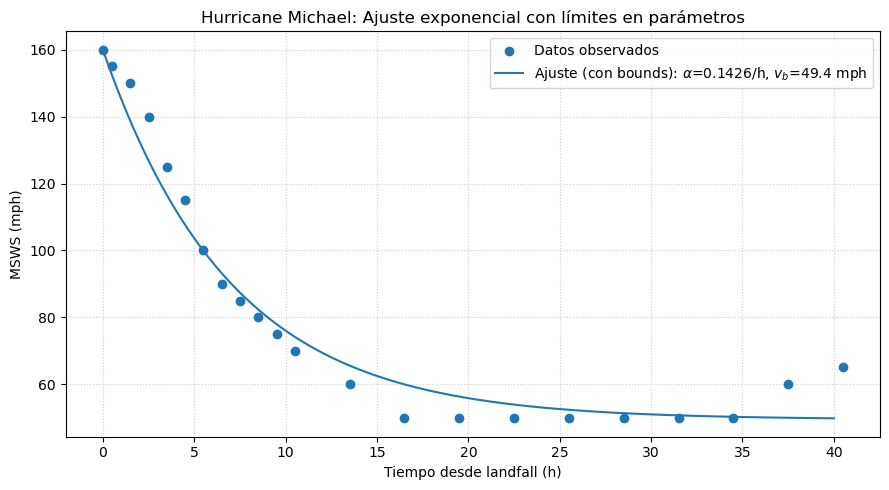

(0.14261573277076686,
 0.011699062890375405,
 49.425704141401205,
 2.88287232082795)

In [ ]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# --- Datos de Michael (t, v) ---
t_michael = np.array([0, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 13.5, 16.5,
                   19.5, 22.5, 25.5, 28.5, 31.5, 34.5, 37.5, 40.5])
v_michael = np.array([160, 155, 150, 140, 125, 115, 100, 90, 85, 80, 75, 70, 60, 50,
                   50, 50, 50, 50, 50, 50, 60, 65])

# --- Modelo ---
def v_model(t, alpha, v_b, v0):
    return v_b + (v0 - v_b) * np.exp(-alpha * t)

# --- Ajuste con bounds: fijar v0 al primer valor ---
v0 = v_michael[0]
def model_for_fit(t, alpha, v_b):
    return v_model(t, alpha, v_b, v0)

# Bounds: alpha in [1e-4, 2.0]  (1e-4 to 2 per hour), v_b in [0, v0]
lower_bounds = [1e-4, 0.0]
upper_bounds = [2.0, v0]
p0 = [0.1, 30]  # initial guesses

popt, pcov = curve_fit(model_for_fit, t_michael, v_michael, p0=p0, bounds=(lower_bounds, upper_bounds), maxfev=100000)
alpha_hat, v_b_hat = popt
# Estimate parameter uncertainties (handle case where pcov may be inf/nan)
with np.errstate(invalid='ignore'):
    perr = np.sqrt(np.diag(pcov))
    perr = np.where(np.isfinite(perr), perr, np.array([np.nan, np.nan]))

# --- Valores predichos ---
t_fit = np.linspace(0, 40, 300)
v_fit = model_for_fit(t_fit, alpha_hat, v_b_hat)

# --- Plot ---
plt.figure(figsize=(9,5))
plt.scatter(t_michael, v_michael, label="Datos observados", zorder=5)
plt.plot(t_fit, v_fit, label=f"Ajuste (con bounds): $\\alpha$={alpha_hat:.4f}/h, $v_b$={v_b_hat:.1f} mph", zorder=4)
plt.xlabel("Tiempo desde landfall (h)")
plt.ylabel("MSWS (mph)")
plt.title("Hurricane Michael: Ajuste exponencial con límites en parámetros")
plt.grid(True, ls=":", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Print results
(alpha_hat, perr[0], v_b_hat, perr[1])


1- La velocidad máxima sostenida de Hurricane Michael disminuye rápidamente después del landfall, con un decaimiento caracterizado por $\alpha \approx 0.143$. Esto significa que cada hora la diferencia entre la velocidad actual y la velocidad límite se reduce aproximadamente un $14\%$.

2- La velocidad límite es cercana a $50~mph$, consistente con la observación de que después de varias horas la tormenta mantiene vientos residuales significativos en tierra.

3- El modelo predice razonablemente los datos iniciales (0–10 h), pero empieza a divergir ligeramente en las horas tardías donde los datos muestran un pequeño repunte (60–65 mph), indicando que factores locales como la interacción con el terreno o nuevas masas de aire podrían afectar la velocidad residual.

# Datos del NHC 
https://www.nhc.noaa.gov/data/

A continuación se desarrolló un script que procesa los datos de huracanes obtenidos de la base del NHC. El flujo general del análisis es el siguiente:  
1. **Carga de datos:** Se importan los registros del huracán, incluyendo tiempo, posición (latitud y longitud) y velocidad del viento.  
2. **Detección de landfall y exit:**  
   - El script identifica los puntos donde el huracán toca tierra (**landfall**) y, si existe, el punto donde regresa al océano (**exit**).  
   - Para asegurar que el huracán realmente interactúe con la tierra, se exige que permanezca al menos 3 horas sobre la superficie. Si no se cumple esta condición, se continúa buscando el siguiente punto que sí lo haga.  
3. **Visualización de la trayectoria:** Se genera un gráfico de la trayectoria del huracán, destacando los puntos de landfall y exit, permitiendo una inspección rápida y clara del paso por tierra.  
4. **Ajuste de parámetros:** Con la sección de la trayectoria sobre tierra, se aplica la metodología previamente descrita para estimar los parámetros $\alpha$ y $v_b$ del modelo de decaimiento del viento, ajustando cada muestra de datos.  

In [1]:
def get_landfall(df_track, land_shapefile = "ne_10m_land/ne_10m_land.shp", tol=0.05, min_duration=3.0, padding=1):
    """
    Detecta el segmento en tierra de un huracán usando duración mínima para confirmar cruces,
    y grafica el track con landfall, track en tierra y salida al mar.

    Parámetros:
    - df_track : DataFrame con columnas ['Date','Time','Lat','Lon', ...]
    - land_shapefile : ruta al shapefile de tierra
    - tol : tolerancia en grados para la intersección
    - min_duration : duración mínima (en horas) que el huracán debe permanecer en tierra (o mar)
    - padding : margen en grados para ajustar el zoom del gráfico

    Retorna:
    - df_land_segment : DataFrame con los puntos en tierra
    - landfall_index : índice del primer punto en tierra
    - exit_index : índice del último punto en tierra
    """
    import geopandas as gpd
    import pandas as pd
    import matplotlib.pyplot as plt
    from shapely.geometry import Point

    # ----------------------------
    # 1. Crear columna datetime
    # ----------------------------
    df_track = df_track.copy()
    df_track["datetime"] = pd.to_datetime(
        df_track["Date"].astype(str) + df_track["Time"].astype(str).str.zfill(4),
        format="%Y%m%d%H%M"
    )

    # ----------------------------
    # 2. Convertir a GeoDataFrame
    # ----------------------------
    df_track["geometry"] = df_track.apply(lambda row: Point(row["Lon"], row["Lat"]), axis=1)
    gdf_track = gpd.GeoDataFrame(df_track, geometry="geometry", crs="EPSG:4326")

    # ----------------------------
    # 3. Leer shapefile de tierra
    # ----------------------------
    land = gpd.read_file(land_shapefile)

    def is_on_land(point, land_polygons, tol=0.1):
        return any(point.buffer(tol).intersects(poly) for poly in land_polygons)

    # ----------------------------
    # 4. Clasificar cada punto agua/tierra
    # ----------------------------
    gdf_track["on_land"] = gdf_track["geometry"].apply(
        lambda p: is_on_land(p, land.geometry, tol)
    )

    # ----------------------------
    # 5. Detectar landfall y salida con duración mínima
    # ----------------------------
    landfall_index, exit_index = None, None
    in_land_counter = 0
    min_duration_pts = int(min_duration)  # ajustar según frecuencia de datos (horas)
    
    for i, on_land_now in enumerate(gdf_track["on_land"]):
        if on_land_now:
            in_land_counter += 1
            if in_land_counter >= min_duration_pts and landfall_index is None:
                # detectar primer punto válido en tierra
                landfall_index = i - in_land_counter + 1
        else:
            if landfall_index is not None and exit_index is None:
                # último punto en tierra antes de salir al mar
                exit_index = i - 1
            in_land_counter = 0

    # Si nunca se salió al mar después de entrar en tierra
    if landfall_index is not None and exit_index is None:
        exit_index = len(gdf_track) - 1

    # ----------------------------
    # 6. Subconjunto del segmento
    # ----------------------------
    if landfall_index is not None:
        df_land_segment = gdf_track.loc[landfall_index:exit_index].reset_index(drop=True)
    else:
        df_land_segment = pd.DataFrame(columns=df_track.columns)

    # ----------------------------
    # 7. Graficar track
    # ----------------------------
    fig, ax = plt.subplots(figsize=(10, 8))
    land.plot(ax=ax, color="lightgray", edgecolor="black")
    gdf_track.plot(ax=ax, color="blue", markersize=30, label="Track completo")

    if not df_land_segment.empty:
        df_land_segment.plot(ax=ax, color="orange", markersize=60, label="Track en tierra")
    if landfall_index is not None:
        gpd.GeoSeries([gdf_track.iloc[landfall_index].geometry]).plot(
            ax=ax, color="red", markersize=100, label="Landfall"
        )
    if exit_index is not None:
        gpd.GeoSeries([gdf_track.iloc[exit_index].geometry]).plot(
            ax=ax, color="green", markersize=100, label="Salida"
        )

    minx, miny, maxx, maxy = gdf_track.total_bounds
    ax.set_xlim(minx - padding, maxx + padding)
    ax.set_ylim(miny - padding, maxy + padding)

    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")
    ax.set_title("Track del Huracán con Landfall y Salida")
    ax.legend()
    ax.grid(True)
    plt.savefig("landfall.png")
    plt.show()

    # ----------------------------
    # 8. Retorno
    # ----------------------------
    return df_land_segment, landfall_index, exit_index


In [10]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas as pd

def fit_hurricane_decay(df):
    """
    Ajusta el modelo exponencial de decaimiento de vientos para un DataFrame de huracán.
    
    Parámetros:
        df : pandas.DataFrame
            Debe contener las columnas "t_hours" (tiempo en horas desde landfall)
            y "Wind" (MSWS en mph).
            Opcional: columna "Name" con el nombre del huracán.
    
    Retorna:
        popt : parámetros ajustados (alpha, v_b, v0)
        perr : incertidumbres estimadas de los parámetros
    """
    # --- Datos ---
    df["Time"] = df["Time"].astype(str).str.zfill(4)

    # Combinar Date y Time
    df["datetime"] = pd.to_datetime(df["Date"].astype(str) + df["Time"], format="%Y%m%d%H%M")
    
    # -----------------------------
    # 2. Calcular tiempo transcurrido en horas desde la primera fila
    # -----------------------------
    df["t_hours"] = (df["datetime"] - df["datetime"].iloc[0]).dt.total_seconds() / 3600
    time = df["t_hours"].values
    wind = df["Wind"].values
    
    # --- Modelo ---
    def v_model(t, alpha, v_b, v0):
        return v_b + (v0 - v_b) * np.exp(-alpha * t)
    
    # --- Ajuste ---
    p0 = [0.1, wind.min(), wind.max()] # valores iniciales: alpha, v_b, v0
    lower_bounds = [1e-4, 0.0, wind.min()]
    upper_bounds = [2.0, wind.max(), wind.max()*1.2]
    print("lower_bounds:", lower_bounds)
    print("upper_bounds:", upper_bounds)
    print("p0:", p0)
    
    popt, pcov = curve_fit(
        v_model, time, wind,
        p0=p0, bounds=(lower_bounds, upper_bounds), maxfev=100000
    )
    alpha_hat, v_b_hat, v0_hat = popt

    
    # --- Incertidumbres ---
    with np.errstate(invalid='ignore'):
        perr = np.sqrt(np.diag(pcov))
        perr = np.where(np.isfinite(perr), perr, np.nan)
    
    # --- Valores predichos ---
    t_fit = np.linspace(0, time.max(), 300)
    v_fit = v_model(t_fit, alpha_hat, v_b_hat, v0_hat)
    
    # --- Nombre del huracán ---
    hurricane_name = df["Name"].iloc[0] if "Name" in df.columns else "Huracán"
    
    # --- Plot ---
    plt.figure(figsize=(9,5))
    plt.scatter(time, wind, label="Datos observados", zorder=5)
    plt.plot(
        t_fit, v_fit,
        label=(f"Ajuste: $\\alpha$={alpha_hat:.4f}/h, "
               f"$v_b$={v_b_hat:.1f} mph, $v_0$={v0_hat:.1f} mph"),
        zorder=4
    )
    plt.xlabel("Tiempo desde landfall (h)")
    plt.ylabel("MSWS (mph)")
    plt.title(f"{hurricane_name}: Ajuste exponencial con $v_0$ libre")
    plt.grid(True, ls=":", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # --- Resultados ---
    print(f"alpha = {alpha_hat:.4f} ± {perr[0]:.4f}")
    print(f"v_b   = {v_b_hat:.1f} ± {perr[1]:.1f}")
    print(f"v_0   = {v0_hat:.1f} ± {perr[2]:.1f}")
    
    return popt, perr


In [11]:
file_path = "nhc_hurdat2.txt"

storms = []
with open(file_path) as f:
    current_id, current_name = None, None
    for line in f:
        if line.startswith(("AL", "EP")):  # Cabecera de tormenta
            header = line.split(",")
            current_id = header[0].strip()
            current_name = header[1].strip()
        else:  # Datos de cada punto de trayectoria
            parts = line.split(",")
            storms.append([
                current_id,
                current_name,
                parts[0].strip(),   # Fecha
                parts[1].strip(),   # Hora
                parts[4].strip(),   # Lat
                parts[5].strip(),   # Lon
                int(parts[6].strip()), # Viento (kt)
                int(parts[7].strip()) if parts[7].strip() != "-999" else None # Presión
            ])

# Crear DataFrame general
df = pd.DataFrame(storms, columns=["ID", "Name", "Date", "Time", "Lat", "Lon", "Wind", "Pressure"])

# Filtrar Michael 2018 (ID = AL142018)
michael = df[df["ID"] == "AL142018"].copy().reset_index(drop=True)
katrina = df[df["ID"] == "AL122005"].copy().reset_index(drop=True)
camille = df[df["ID"] == "AL091969"].copy().reset_index(drop=True)
irma = df[df["ID"] == "AL191978"].copy().reset_index(drop=True)
audrey = df[df["ID"] == "AL021957"].copy().reset_index(drop=True)


# Convertir coordenadas a números
def convert_coord(val):
    if val.endswith(("N", "E")):
        return float(val[:-1])
    else:
        return -float(val[:-1])

michael["Lat"] = michael["Lat"].apply(convert_coord)
michael["Lon"] = michael["Lon"].apply(convert_coord)
katrina["Lat"] = katrina["Lat"].apply(convert_coord)
katrina["Lon"] = katrina["Lon"].apply(convert_coord)
camille["Lat"] = camille["Lat"].apply(convert_coord)
camille["Lon"] = camille["Lon"].apply(convert_coord)
irma["Lat"] = irma["Lat"].apply(convert_coord)
irma["Lon"] = irma["Lon"].apply(convert_coord)
audrey["Lat"] = audrey["Lat"].apply(convert_coord)
audrey["Lon"] = audrey["Lon"].apply(convert_coord)

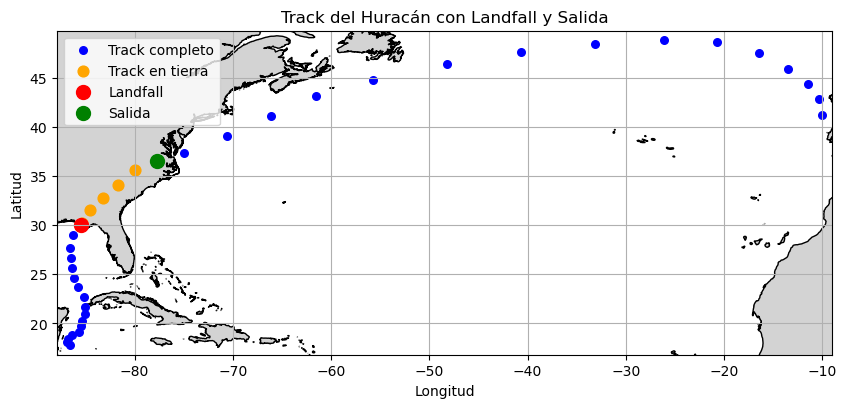

Índice del landfall: 16
Puntos desde el landfall en adelante:
         ID     Name      Date  Time   Lat   Lon  Wind  Pressure  \
0  AL142018  MICHAEL  20181010  1730  30.0 -85.5   140     919.0   
1  AL142018  MICHAEL  20181010  1800  30.2 -85.4   135     920.0   
2  AL142018  MICHAEL  20181011  0000  31.5 -84.5    80     957.0   
3  AL142018  MICHAEL  20181011  0600  32.8 -83.2    50     979.0   
4  AL142018  MICHAEL  20181011  1200  34.1 -81.7    45     987.0   

             datetime            geometry  on_land  
0 2018-10-10 17:30:00    POINT (-85.5 30)     True  
1 2018-10-10 18:00:00  POINT (-85.4 30.2)     True  
2 2018-10-11 00:00:00  POINT (-84.5 31.5)     True  
3 2018-10-11 06:00:00  POINT (-83.2 32.8)     True  
4 2018-10-11 12:00:00  POINT (-81.7 34.1)     True  


In [18]:
df_landfall_michael, landfall_index_michael, exit_index_michael = get_landfall(michael)


print("Índice del landfall:", landfall_index_michael)
print("Puntos desde el landfall en adelante:")
print(df_landfall_michael.head())

lower_bounds: [0.0001, 0.0, 45]
upper_bounds: [2.0, 140, 168.0]
p0: [0.1, 45, 140]


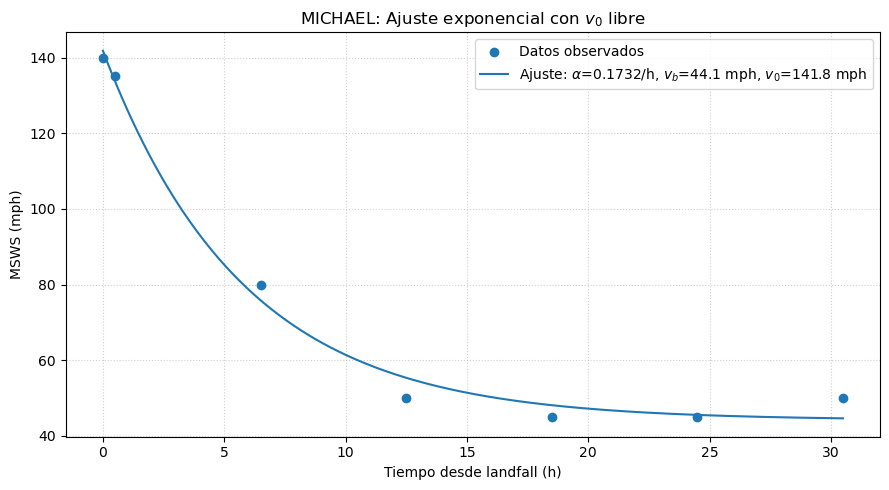

alpha = 0.1732 ± 0.0269
v_b   = 44.1 ± 3.4
v_0   = 141.8 ± 3.6


In [19]:
popt, perr = fit_hurricane_decay(df_landfall_michael)

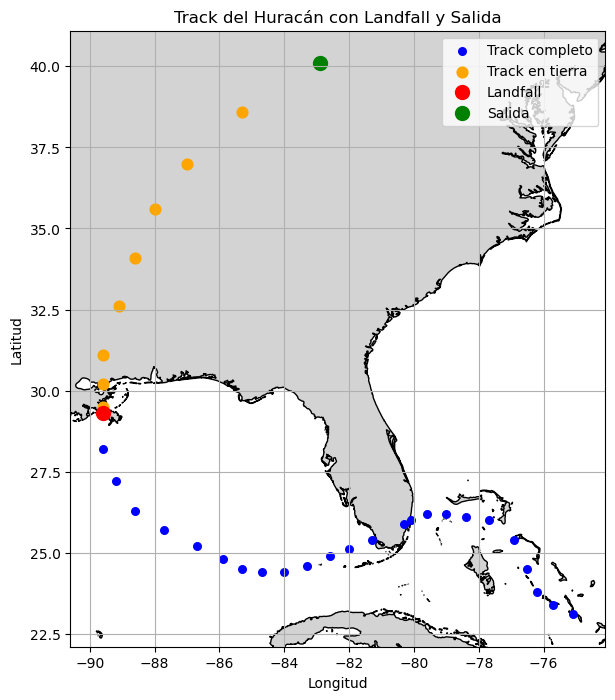

Índice del landfall: 24
Puntos desde el landfall en adelante:
         ID     Name      Date  Time   Lat   Lon  Wind  Pressure  \
0  AL122005  KATRINA  20050829  1110  29.3 -89.6   110     920.0   
1  AL122005  KATRINA  20050829  1200  29.5 -89.6   110     923.0   
2  AL122005  KATRINA  20050829  1445  30.2 -89.6   105     928.0   
3  AL122005  KATRINA  20050829  1800  31.1 -89.6    80     948.0   
4  AL122005  KATRINA  20050830  0000  32.6 -89.1    50     961.0   

             datetime            geometry  on_land  
0 2005-08-29 11:10:00  POINT (-89.6 29.3)     True  
1 2005-08-29 12:00:00  POINT (-89.6 29.5)     True  
2 2005-08-29 14:45:00  POINT (-89.6 30.2)     True  
3 2005-08-29 18:00:00  POINT (-89.6 31.1)     True  
4 2005-08-30 00:00:00  POINT (-89.1 32.6)     True  


In [20]:
df_landfall_katrina, landfall_index_katrina, exit_index_katrina= get_landfall(katrina)

print("Índice del landfall:", landfall_index_katrina)
print("Puntos desde el landfall en adelante:")
print(df_landfall_katrina.head())

lower_bounds: [0.0001, 0.0, 25]
upper_bounds: [2.0, 110, 132.0]
p0: [0.1, 25, 110]


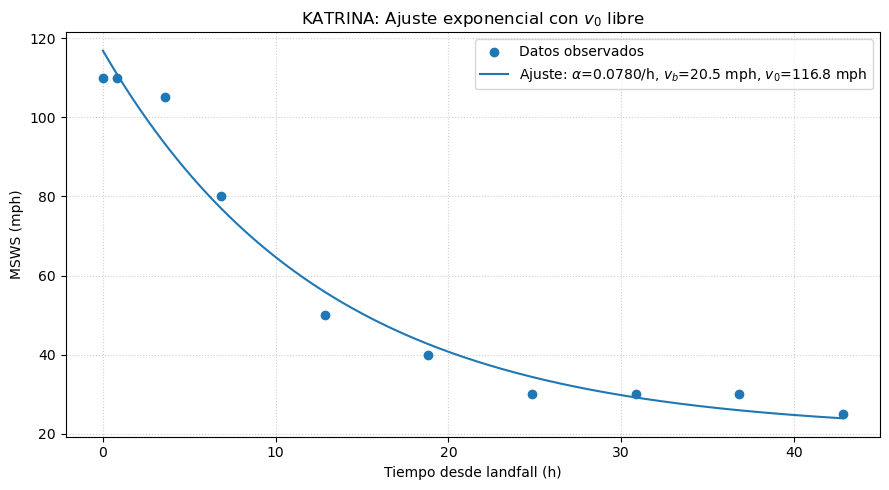

alpha = 0.0780 ± 0.0154
v_b   = 20.5 ± 6.0
v_0   = 116.8 ± 4.4


In [21]:
popt, perr = fit_hurricane_decay(df_landfall_katrina)

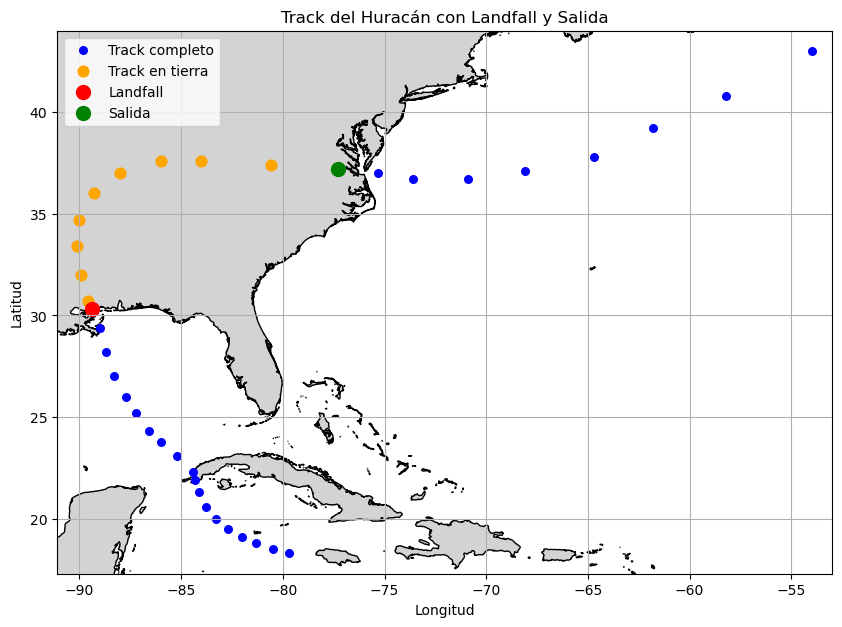

Índice del landfall: 18
Puntos desde el landfall en adelante:
         ID     Name      Date  Time   Lat   Lon  Wind  Pressure  \
0  AL091969  CAMILLE  19690818  0400  30.3 -89.4   150     900.0   
1  AL091969  CAMILLE  19690818  0600  30.7 -89.6   115       NaN   
2  AL091969  CAMILLE  19690818  1200  32.0 -89.9    75       NaN   
3  AL091969  CAMILLE  19690818  1800  33.4 -90.1    50       NaN   
4  AL091969  CAMILLE  19690819  0000  34.7 -90.0    35       NaN   

             datetime            geometry  on_land  
0 1969-08-18 04:00:00  POINT (-89.4 30.3)     True  
1 1969-08-18 06:00:00  POINT (-89.6 30.7)     True  
2 1969-08-18 12:00:00    POINT (-89.9 32)     True  
3 1969-08-18 18:00:00  POINT (-90.1 33.4)     True  
4 1969-08-19 00:00:00    POINT (-90 34.7)     True  


In [22]:
df_landfall_camille, landfall_index_camille, exit_index_camille = get_landfall(camille)

print("Índice del landfall:", landfall_index_camille)
print("Puntos desde el landfall en adelante:")
print(df_landfall_camille.head())

lower_bounds: [0.0001, 0.0, 25]
upper_bounds: [2.0, 150, 180.0]
p0: [0.1, 25, 150]


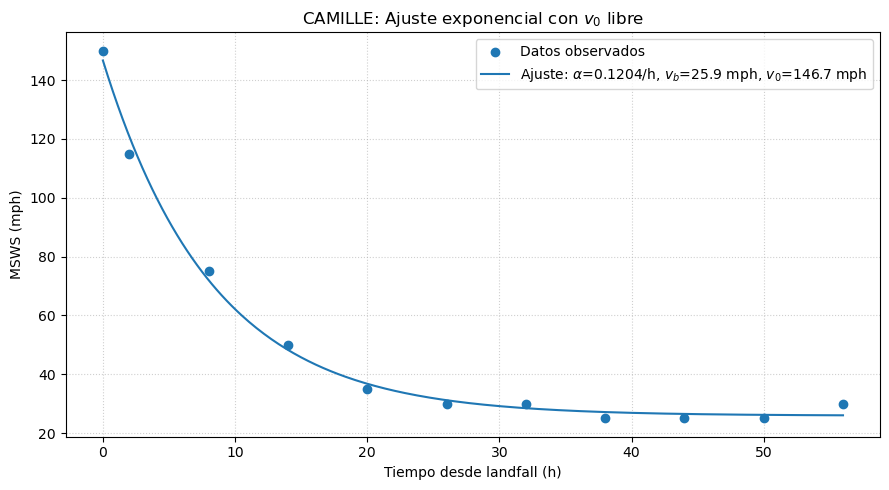

alpha = 0.1204 ± 0.0082
v_b   = 25.9 ± 1.5
v_0   = 146.7 ± 2.8


In [23]:
popt, perr = fit_hurricane_decay(df_landfall_camille)

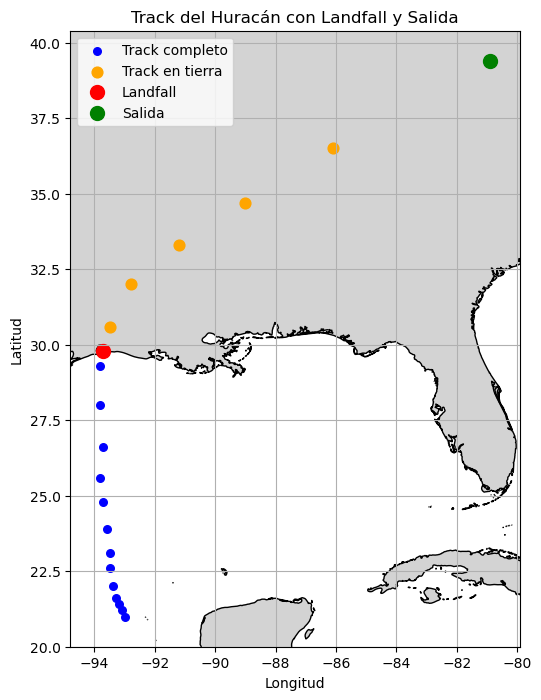

Índice del landfall: 13
Puntos desde el landfall en adelante:
         ID    Name      Date  Time   Lat   Lon  Wind  Pressure  \
0  AL021957  AUDREY  19570627  1330  29.8 -93.7   110     946.0   
1  AL021957  AUDREY  19570627  1800  30.6 -93.5    80       NaN   
2  AL021957  AUDREY  19570628  0000  32.0 -92.8    55       NaN   
3  AL021957  AUDREY  19570628  0600  33.3 -91.2    40       NaN   
4  AL021957  AUDREY  19570628  1200  34.7 -89.0    35       NaN   

             datetime            geometry  on_land  
0 1957-06-27 13:30:00  POINT (-93.7 29.8)     True  
1 1957-06-27 18:00:00  POINT (-93.5 30.6)     True  
2 1957-06-28 00:00:00    POINT (-92.8 32)     True  
3 1957-06-28 06:00:00  POINT (-91.2 33.3)     True  
4 1957-06-28 12:00:00    POINT (-89 34.7)     True  


In [24]:
df_landfall_audrey, landfall_index_audrey, exit_index_audrey = get_landfall(audrey)

print("Índice del landfall:", landfall_index_audrey)
print("Puntos desde el landfall en adelante:")
print(df_landfall_audrey.head())

lower_bounds: [0.0001, 0.0, 35]
upper_bounds: [2.0, 110, 132.0]
p0: [0.1, 35, 110]


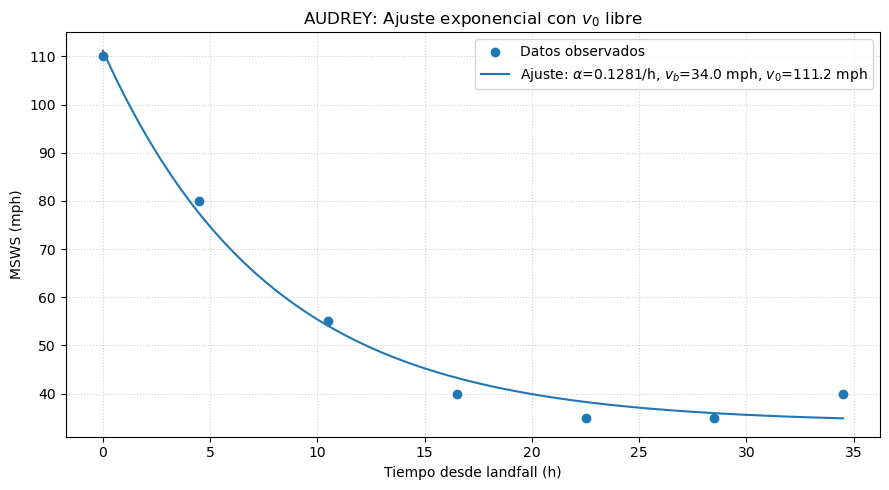

alpha = 0.1281 ± 0.0191
v_b   = 34.0 ± 2.9
v_0   = 111.2 ± 3.7


In [25]:
popt, perr = fit_hurricane_decay(df_landfall_audrey)

## Hasta acá va lo que está probado y funcionando, a continuación quería mejorar la función que usamos para ajustar a los puntos agregando algunas de las variables que nombro al inicio del archivo, pero aún no esta funcionando bien. Sigo trabajando en eso, con el objetivo de conseguir un mejor ajuste.

In [188]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# Ruta al archivo descargado
archivo = "consensus_full_class_12.tif"  # reemplaza con la ruta real

# Abrir el raster
with rasterio.open(archivo) as src:
    terrain_data = src.read(1)  # lee la primera banda
    bounds = src.bounds        # límites geográficos
    transform = src.transform  # transformación de coordenadas
    crs = src.crs              # sistema de referencia espacial

print("Dimensiones:", terrain_data.shape)
print("Valores mínimos y máximos:", terrain_data.min(), terrain_data.max())
print("Límites:", bounds)
print("CRS:", crs)


Dimensiones: (17520, 43200)
Valores mínimos y máximos: 0 100
Límites: BoundingBox(left=-180.00000000000003, bottom=-56.000000000000014, right=180.00000000000003, top=90.00000000000001)
CRS: EPSG:4326


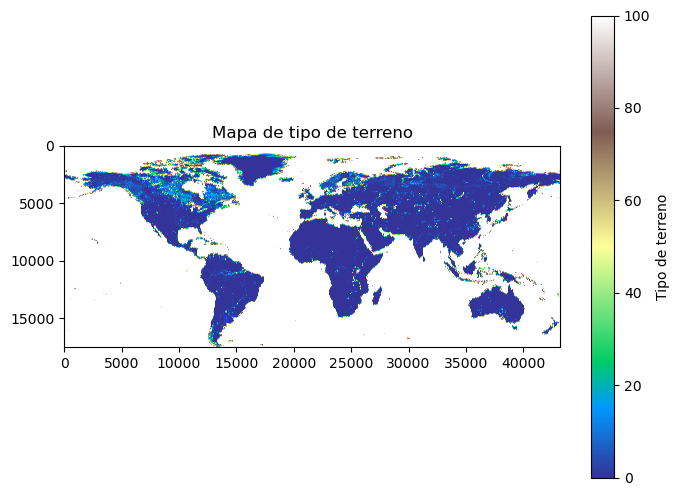

In [189]:
plt.figure(figsize=(8,6))
plt.imshow(terrain_data, cmap='terrain')
plt.colorbar(label='Tipo de terreno')
plt.title('Mapa de tipo de terreno')
plt.show()


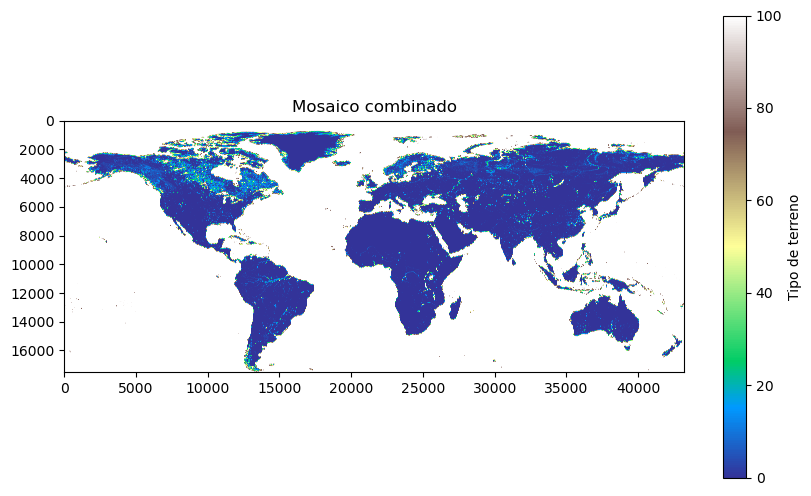

In [191]:
from rasterio.merge import merge
archivos = ["consensus_full_class_12.tif", "consensus_full_class_11.tif", "consensus_full_class_9.tif", "consensus_full_class_1.tif"]

src_files_to_mosaic = [rasterio.open(f) for f in archivos]
mosaic, out_trans = merge(src_files_to_mosaic, res=src_files_to_mosaic[0].res)

out_meta = src_files_to_mosaic[0].meta.copy()
out_meta.update({
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_trans
})

with rasterio.open("mosaico_global.tif", "w", **out_meta) as dest:
    dest.write(mosaic)
    
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.imshow(mosaic[0], cmap='terrain')
plt.colorbar(label='Tipo de terreno')
plt.title('Mosaico combinado')
plt.show()



In [8]:
from scipy.interpolate import RegularGridInterpolator
import numpy as np

# -----------------------------
# Crear interpolador sobre el mosaico
# -----------------------------
# mosaic[0] -> primera banda del mosaico
terrain_data_flip = np.flipud(mosaic[0])  # invertir eje vertical
rows, cols = terrain_data_flip.shape
transform = out_trans

# coordenadas de los centros de los píxeles
lat = np.array([transform[5] + (i + 0.5) * transform[4] for i in range(rows)])[::-1]
lon = np.array([transform[2] + (j + 0.5) * transform[0] for j in range(cols)])

terrain_interp = RegularGridInterpolator(
    (lat, lon),
    terrain_data_flip,
    bounds_error=False,
    fill_value=0
)

# -----------------------------
# Función f_terrain_time
# -----------------------------
def f_terrain_time(lat_pts, lon_pts, t=0, v0=155, vb=50, alpha=0.1):
    """
    Calcula la velocidad del viento ajustada por terreno y tiempo post-landfall.
    
    Parámetros:
        lat_pts, lon_pts: arrays o valores escalares de coordenadas
        t: tiempo tras landfall (horas)
        v0: velocidad inicial (mph)
        vb: velocidad límite tras varias horas (mph)
        alpha: constante de decaimiento (1/h)
        
    Retorna:
        velocidad ajustada (array o escalar)
    """
    # Asegurarse que lat_pts/lon_pts sean arrays
    lat_pts = np.atleast_1d(lat_pts)
    lon_pts = np.atleast_1d(lon_pts)
    
    # Interpolación de tipo de terreno
    terr = terrain_interp(np.column_stack([lat_pts, lon_pts]))
    
    # Ajuste según terreno
    terrain_decay = {0:0.95,1:0.85,2:0.75,3:0.7,4:0.6}
    terrain_factor = np.array([terrain_decay.get(int(ti), 0.8) for ti in terr])
    
    # Decaimiento temporal post-landfall
    time_factor = vb + (v0 - vb) * np.exp(-alpha * t)
    
    return terrain_factor * time_factor


In [ ]:
# Velocidad en un punto específico
v = f_terrain_time(25.5, -80.5, t=3)  # lat, lon, 3 horas tras landfall
print("Velocidad del viento ajustada:", v)

# Velocidad sobre todo el mosaico (vectorizada)
lat_grid, lon_grid = np.meshgrid(lat, lon, indexing='ij')
wind_map = f_terrain_time(lat_grid.ravel(), lon_grid.ravel(), t=3).reshape(rows, cols)

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.imshow(wind_map, cmap='viridis')
plt.colorbar(label='Velocidad del viento (mph)')
plt.title('Velocidad del viento tras 3 horas (ajustada por terreno)')
plt.show()


Velocidad del viento ajustada: [121.39661751]
